In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from tqdm import tqdm
import pickle

mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
pd.options.display.max_columns = 60

In [2]:
df_mi = pd.read_csv('data/Medical_Image_Data_01.csv', encoding='cp949')
df_pd = pd.read_csv('data/Patient_Diagnosis_Data.csv')
df_ps = pd.read_csv('data/Patient_Surgery_Data.csv')

In [3]:
df = pd.merge(df_mi, df_pd)
df = pd.merge(df, df_ps)
# df.info()

### 데이터 타입 변경 (df2)

연속형 데이터 -> 범주형 데이터
* 과거수술횟수 범주형으로 할지 연속형으로 할지 애매함

In [4]:
def num_to_cat(df, change_col):
    df = df.copy()
    
    for i in change_col:
        df[i] = df[i].astype('object')
    
    return df

In [5]:
change_col = ['가족력', '간질성폐질환', '고혈압여부', '과거수술횟수', '당뇨여부', 
              '말초동맥질환여부', '빈혈여부', '성별', '스테로이드치료', '신부전여부',
              '심혈관질환', '암발병여부', '우울증여부', '종양진행여부', '혈전합병증여부','흡연여부',
              'Instability', 'Modic change', 'Vaccum disc', '척추전방위증', 'Location of herniation',
              '디스크위치', '수술실패여부', '재발여부']

In [6]:
df2 = num_to_cat(df, change_col)
# df2.info()

연속형 데이터 -> 날짜형 데이터

In [7]:
def num_to_date(df, change_col):
    df = df.copy()
    
    for i in change_col:
        df[i] = df[i].apply(lambda x: str(x))
    for i in change_col:
        df[f'{i}_dt'] = pd.to_datetime(df[i])
    return df

In [8]:
change_col = ['입원일자', '수술일자', '퇴원일자']

In [9]:
df2 = num_to_date(df2, change_col)
# df2.info()

---------------------------------------------------------------------

### 이상치 확인

범주형 데이터 이상치 확인

In [10]:
# category_col = df.describe(include='object').columns
# print(category_col)

# for c in category_col:
#     sns.countplot(data=df, y=c)
#     plt.show()

연속형 데이터 이상치 확인

In [11]:
# numeric_col = df.describe().columns
# print(numeric_col)

# for n in numeric_col:
#     sns.boxplot(data=df, x=n)
#     plt.show()

연속형 데이터 이상치 개수 확인

In [12]:
def count_outlier(df):
    numeric_col = df.describe().columns
    print(numeric_col)
    print('이상치')
    for n in numeric_col:
        q1 = df[n].quantile(0.25)
        q3 = df[n].quantile(0.75)
        iqr = q3 - q1
        bottom = q1 - 1.5 * iqr
        top = q3 + 1.5 * iqr
        
        cond1 = (df[n] < bottom)
        cond2 = (df[n] > top)
        
        print(n)
        print(len(df[cond1 | cond2]))

In [13]:
# count_outlier(df2)

------------------------------------------------------

### 결측치 대체 (df3)

In [10]:
# 통증기간(월) -> 최빈값으로 대체
replace_dict = {'통증기간(월)': df2['통증기간(월)'].sort_values()[0]}

df3 = df2.fillna(value=replace_dict)
# df3.info()

### 결측치 제거 (df4)

In [11]:
# 헤모글로빈수치 1개, 지방축적도 3개, PI 4개, Seg Angle(raw) 1개, 디스크단면적 1개
drop_col = ['헤모글로빈수치', '지방축적도', 'PI', 'Seg Angle(raw)', '디스크단면적']

df4 = df3.dropna(subset=drop_col)
# df4.info()
# 가족력은 사용하지 않을 것 같아 결측치 제거 안 함
# PT 결측치는 PI랑 같이 제거됨
# 총 10개 제거됨

### 이상치 대체 (df5)

In [12]:
df5 = df4.copy()

# PI 559인 이상치 3개 55.9로 대체
new_pi = df5['PI'].replace({559.0: 55.9})
df5['PI'] = new_pi
# df5.info()

### 이상치 제거 (df6)

In [13]:
# 우울증여부가 2인 이상치 1개 제거
df6 = df5.drop([df5[df5['우울증여부'] == 2].index[0]], axis=0)
# 후방디스크높이(mm)가 101.0인 이상치 3개 제거
df6.drop(df6[df6['후방디스크높이(mm)'] == 101.0].index, axis=0, inplace=True)
# 지방 축적도 6000 이상인 이상치 2개 제거
df6.drop(df6[df6['지방축적도'] > 6000].index, axis=0, inplace=True)
# Seg Angle(raw) 165인 이상치 3개 제거
df6.drop(df6[df6['Seg Angle(raw)'] == 165].index, axis=0, inplace=True)
# df6.info()
# 키 168cm 몸무게 136kg인 이상치 1개는 헤모글로빈 결측치 제거하면서 같이 제거됨
# 총 9개 제거

-----총 19행 삭제-----

### 파생변수 생성

In [14]:
def bmi(data):
    if data >= 25:
        return '비만'
    elif data >= 23:
        return '과체중'
    elif data >= 18.5:
        return '정상'
    else:
        return '저체중'
    
def age(data):
    if data >= 60:
        return '60대 이상'
    elif data >= 50:
        return '50대'
    elif data >= 40:
        return '40대'
    elif data >= 30:
        return '30대'
    else:
        return '20대 이하'

In [15]:
df6['BMI'] = df6['체중'] / df6['신장'].apply(lambda x: (x / 100)**2)
df6['BMI_cat'] = df6['BMI'].apply(bmi)
df6['연령대'] = df6['연령'].apply(lambda x: f'{x // 10}0대')
df6['연령대2'] = df6['연령'].apply(age)
df6['연령+성별'] = df6['연령대2'] + df6['성별'].astype(str)

### --------------------------------------

In [41]:
# df6.to_csv('Merged_Data.csv')

In [16]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1875 entries, 0 to 1893
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   환자ID                    1875 non-null   object        
 1   전방디스크높이(mm)             1875 non-null   float64       
 2   후방디스크높이(mm)             1875 non-null   float64       
 3   지방축적도                   1875 non-null   float64       
 4   Instability             1875 non-null   object        
 5   MF + ES                 1875 non-null   float64       
 6   Modic change            1875 non-null   object        
 7   PI                      1875 non-null   float64       
 8   PT                      1875 non-null   float64       
 9   Seg Angle(raw)          1875 non-null   float64       
 10  Vaccum disc             1875 non-null   object        
 11  골밀도                     988 non-null    float64       
 12  디스크단면적                  1875 non-null   float64 

In [88]:
# 퇴원일자_dt 이상치 20개 제거
df_temp = df6.drop(df6[(df6['퇴원일자_dt'] < df6['입원일자_dt'])].index, axis=0)
df_temp['입원일자_dt'].dt.day_name().value_counts()

Tuesday      366
Thursday     320
Monday       319
Wednesday    300
Sunday       200
Friday       197
Saturday     148
Name: 입원일자_dt, dtype: int64

In [89]:
df_temp['수술일자_dt'].dt.day_name().value_counts()

Wednesday    362
Friday       358
Thursday     341
Monday       286
Tuesday      285
Saturday     134
Sunday        84
Name: 수술일자_dt, dtype: int64

In [90]:
df_temp['퇴원일자_dt'].dt.day_name().value_counts()

Friday       330
Thursday     325
Wednesday    320
Saturday     297
Tuesday      277
Monday       181
Sunday       120
Name: 퇴원일자_dt, dtype: int64

In [146]:
df_temp['입원기간'] = df_temp['퇴원일자_dt'] - df_temp['입원일자_dt']
df_temp['입원기간'] = df_temp['입원기간'].astype(str)
df_temp['입원기간'] = df_temp['입원기간'].apply(lambda x: int(x.split(' ')[0]))
df_temp.sort_values(by='입원기간', ascending=False)

,환자ID,전방디스크높이(mm),후방디스크높이(mm),지방축적도,Instability,MF + ES,Modic change,PI,PT,Seg Angle(raw),Vaccum disc,골밀도,디스크단면적,디스크위치,척추이동척도,척추전방위증,Large Lymphocyte,Location of herniation,ODI,가족력,간질성폐질환,고혈압여부,과거수술횟수,당뇨여부,말초동맥질환여부,빈혈여부,성별,스테로이드치료,신부전여부,신장,심혈관질환,암발병여부,연령,우울증여부,입원기간,입원일자,종양진행여부,직업,체중,퇴원일자,헤모글로빈수치,혈전합병증여부,환자통증정도,흡연여부,통증기간(월),수술기법,수술시간,수술실패여부,수술일자,재발여부,혈액형,입원일자_dt,수술일자_dt,퇴원일자_dt,BMI,BMI_cat,연령대,연령대2,연령+성별
1019,1020PT,10.90,8.30,121.60,0,1883.30,0,57.3,13.8,31.7,0,-1.7,1257.50,4,Down,0,61.7,3,21.0,1.0,0,0,0,0,0,0,2,1,0,162,0,0,27,0,1125,20090130,0,교사,57.0,20120229,13.1,0,8,0,4.0,TELD,55.0,0,20090130,0,RH+O,2009-01-30,2009-01-30,2012-02-29,21.719250,정상,20대,20대 이하,20대 이하2
1014,1015PT,13.60,8.00,126.90,0,2035.90,0,41.2,15.7,17.6,0,NaN,2285.50,5,Down,0,48.8,2,24.0,0.0,0,0,0,0,0,0,1,0,0,176,0,0,29,0,757,20100202,0,건설업,93.0,20120229,16.9,0,8,1,3.0,TELD,70.0,0,20100203,1,RH+O,2010-02-02,2010-02-03,2012-02-29,30.023244,비만,20대,20대 이하,20대 이하1
1033,1034PT,13.90,7.50,107.50,0,1897.10,0,54.2,17.1,25.8,0,NaN,1665.80,4,Down,0,52.3,3,27.0,0.0,0,0,2,0,0,0,1,1,0,169,0,0,39,0,674,20100426,0,사무직,62.0,20120229,15.6,0,9,1,4.0,TELD,50.0,0,20100426,0,RH+A,2010-04-26,2010-04-26,2012-02-29,21.707923,정상,30대,30대,30대1
1034,1035PT,9.40,8.20,338.60,0,1687.00,0,30.6,16.5,-5.0,0,NaN,1858.20,3,Down,0,34.9,3,NaN,0.0,0,0,0,0,0,0,2,1,0,165,0,0,38,0,398,20110127,0,무직,58.0,20120229,11.9,0,7,1,3.0,TELD,55.0,0,20110127,0,RH+B,2011-01-27,2011-01-27,2012-02-29,21.303949,정상,30대,30대,30대2
1031,1032PT,13.10,8.50,192.90,0,1203.30,0,66.9,31.0,7.3,0,-1.5,1583.80,3,Middle,0,46.2,3,31.0,0.0,0,0,0,0,0,1,2,1,0,152,1,0,66,0,318,20110417,0,무직,50.0,20120229,11.0,0,8,0,4.5,TELD,25.0,0,20110418,0,RH+B,2011-04-17,2011-04-18,2012-02-29,21.641274,정상,60대,60대 이상,60대 이상2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,1794PT,11.70,7.00,283.10,0,2399.75,1,40.4,13.2,17.9,1,NaN,2613.81,4,Down,0,28.7,2,NaN,0.0,0,0,0,1,0,0,1,1,0,171,1,0,61,0,0,20151127,0,자영업,72.0,20151127,13.2,0,8,0,1.0,TELD,60.0,0,20151127,0,RH+A,2015-11-27,2015-11-27,2015-11-27,24.622961,과체중,60대,60대 이상,60대 이상1
1786,1787PT,12.40,11.10,166.48,0,2332.75,0,30.7,2.3,20.4,0,NaN,2203.83,4,Middle,0,45.8,4,NaN,0.0,0,0,0,0,0,0,1,1,0,174,0,0,36,0,0,20130313,0,무직,60.0,20130313,15.6,0,7,0,4.0,TELD,60.0,0,20130313,0,RH+B,2013-03-13,2013-03-13,2013-03-13,19.817677,정상,30대,30대,30대1
1784,1785PT,9.40,8.70,118.04,0,3241.98,0,35.6,10.7,8.4,0,NaN,2324.83,4,Middle,1,24.9,1,NaN,0.0,0,0,0,0,0,0,1,0,0,176,0,0,33,0,0,20130525,0,사무직,82.0,20130525,15.7,0,8,1,5.0,TELD,60.0,0,20130525,0,RH+A,2013-05-25,2013-05-25,2013-05-25,26.472107,비만,30대,30대,30대1
1284,1285PT,15.21,8.16,317.06,0,2454.13,0,52.9,12.3,30.2,0,NaN,2284.50,5,Down,0,62.7,2,NaN,1.0,0,1,0,0,1,0,1,0,0,172,0,0,55,0,0,20111027,0,사무직,59.0,20111027,14.0,0,3,0,36.0,IELD,80.0,0,20111027,0,RH+A,2011-10-27,2011-10-27,2011-10-27,19.943213,정상,50대,50대,50대1


사무직인 환자의 연령대와 성별 파악

In [17]:
df6[df6['직업'] == '사무직'].pivot_table(index='연령대', columns='성별', values='환자ID', aggfunc='count')

성별,1,2
연령대,,
20대,34,20
30대,129,84
40대,80,38
50대,38,13
60대,2,2
70대,1,1


### 가설검정

재발여부 별 'BMI', '전방디스크높이(mm)', '후방디스크높이(mm)', '지방축적도', 'MF + ES', 'PI', 'PT', 'Seg Angle(raw)', '디스크단면적'의 평균의 차이가 있는지 가설검정

In [56]:
cond0 = (df6['재발여부'] == 0)
cond1 = (df6['재발여부'] == 1)

lst = ['BMI', '전방디스크높이(mm)', '후방디스크높이(mm)', '지방축적도', 'MF + ES', 'PI', 'PT', 'Seg Angle(raw)', '디스크단면적']

재발여부에 따른 환자의 BMI의 평균이 차이가 있는지 검정

In [75]:
def test(lst):
    n = 0
    for i in lst:
        print(f'<재발여부 별 연속형 변수 {i}의 평균의 차이가 있는지 가설검정>\n')
        print('• 정규성검정')
        p1 = stats.normaltest(df6[i]).pvalue
        if p1 >= 0.05:
            print(f'  p value {p1} >= 0.05\n  귀무가설이 참')
            n == 1
        else:
            print(f'  p value {p1} < 0.05\n  대립가설이 참')
            n == 0
        
        print()
        if n == 0:
            print('• 연속형 변수가 정규분포를 따르지 않는 경우 두 집단의 평균을 비교')
            p2 = stats.ranksums(df6[cond0][i], df6[cond1][i]).pvalue
            if p2 >= 0.05:
                print(f'  p value {p2} >= 0.05\n  귀무가설이 참\n  -> 재발하지 않은 환자의 {i}의 평균과 재발한 환자의 {i}의 평균은 차이가 없다')
            else:
                print(f'  p value {p2} < 0.05\n  대립가설이 참\n  -> 재발하지 않은 환자의 {i}의 평균과 재발한 환자의 {i}의 평균은 차이가 있다')
        
        # 정규분포를 따르는 경우는 없어서 빠져있음
              
        print('-' * 80)

In [76]:
test(lst)

<재발여부 별 연속형 변수 BMI의 평균의 차이가 있는지 가설검정>

• 정규성검정
  p value 1.0299197405749234e-49 < 0.05
  대립가설이 참

• 연속형 변수가 정규분포를 따르지 않는 경우 두 집단의 평균을 비교
  p value 1.3036261038373485e-09 < 0.05
  대립가설이 참
  -> 재발하지 않은 환자의 BMI의 평균과 재발한 환자의 BMI의 평균은 차이가 있다
--------------------------------------------------------------------------------
<재발여부 별 연속형 변수 전방디스크높이(mm)의 평균의 차이가 있는지 가설검정>

• 정규성검정
  p value 2.007338864855451e-07 < 0.05
  대립가설이 참

• 연속형 변수가 정규분포를 따르지 않는 경우 두 집단의 평균을 비교
  p value 0.922819263514477 >= 0.05
  귀무가설이 참
  -> 재발하지 않은 환자의 전방디스크높이(mm)의 평균과 재발한 환자의 전방디스크높이(mm)의 평균은 차이가 없다
--------------------------------------------------------------------------------
<재발여부 별 연속형 변수 후방디스크높이(mm)의 평균의 차이가 있는지 가설검정>

• 정규성검정
  p value 2.1107047266481188e-13 < 0.05
  대립가설이 참

• 연속형 변수가 정규분포를 따르지 않는 경우 두 집단의 평균을 비교
  p value 0.9143443309264158 >= 0.05
  귀무가설이 참
  -> 재발하지 않은 환자의 후방디스크높이(mm)의 평균과 재발한 환자의 후방디스크높이(mm)의 평균은 차이가 없다
--------------------------------------------------------------------------------
<재발여부 

(연령대 + 성별)별 재발여부의 독립성 검정

In [59]:
ct = pd.crosstab(df6['연령+성별'], df6['재발여부'])
stats.chi2_contingency(ct)

(17.300761814200573,
 0.04420918316028991,
 9,
 array([[224.264     ,  30.736     ],
        [116.0896    ,  15.9104    ],
        [252.40693333,  34.59306667],
        [156.54506667,  21.45493333],
        [318.36693333,  43.63306667],
        [186.44693333,  25.55306667],
        [136.31733333,  18.68266667],
        [102.01813333,  13.98186667],
        [ 83.54933333,  11.45066667],
        [ 72.99573333,  10.00426667]]))

(연령대 + 성별)별 환자통증정도 평균 차이가 있는지 검정

In [18]:
stats.normaltest(df6['환자통증정도'])
# p value < 0.05 대립가설 참 -> 정규분포를 따르지 않음
stats.kruskal(df6[df6['연령+성별'] == '20대 이하1']['환자통증정도'],
              df6[df6['연령+성별'] == '20대 이하2']['환자통증정도'],
              df6[df6['연령+성별'] == '30대1']['환자통증정도'],
              df6[df6['연령+성별'] == '30대2']['환자통증정도'],
              df6[df6['연령+성별'] == '40대1']['환자통증정도'],
              df6[df6['연령+성별'] == '40대2']['환자통증정도'],
              df6[df6['연령+성별'] == '50대1']['환자통증정도'],
              df6[df6['연령+성별'] == '50대2']['환자통증정도'],
              df6[df6['연령+성별'] == '60대 이상1']['환자통증정도'],
              df6[df6['연령+성별'] == '60대 이상2']['환자통증정도'])
# p value > 0.05 귀무가설 참 -> 집단 간 평균은 같다

KruskalResult(statistic=7.965856713421251, pvalue=0.5375906833277213)

### -----------------------------------------------------------

### 시각화

bmi별 재발확률 그래프

['0.0%', '2.5%', '5.0%', '7.5%', '10.0%', '12.5%', '15.0%', '17.5%', '20.0%']
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2  ]


([<matplotlib.axis.YTick at 0x2a688174670>,
 [Text(0, 0.0, '0.0%'),
  Text(0, 0.025, '2.5%'),
  Text(0, 0.05, '5.0%'),
  Text(0, 0.07500000000000001, '7.5%'),
  Text(0, 0.1, '10.0%'),
  Text(0, 0.125, '12.5%'),
  Text(0, 0.15000000000000002, '15.0%'),
  Text(0, 0.17500000000000002, '17.5%'),
  Text(0, 0.2, '20.0%')])

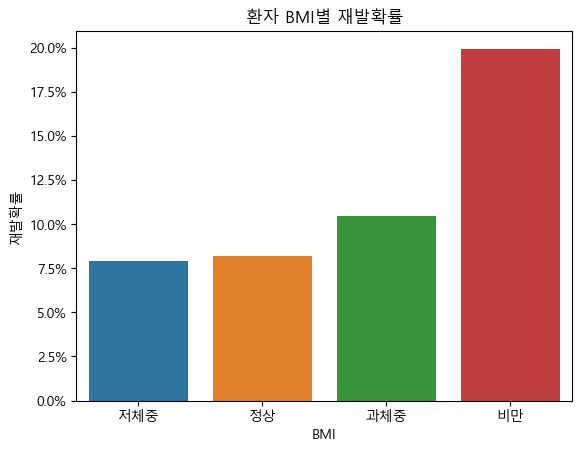

In [132]:
p = df6.pivot_table(index='BMI_cat', values='재발여부', aggfunc='mean')
p = p.loc[['저체중', '정상', '과체중', '비만']]
p = p.reset_index()
p
yt = np.arange(0, 21, 2.5)
yt2 = []
for i in yt:
    i = str(i) + '%'
    yt2.append(i)
print(yt2)
y = np.arange(0, 0.21, 0.025)
print(y)
sns.barplot(data=p, x='BMI_cat', y='재발여부', errorbar=None)
plt.title('환자 BMI별 재발확률')
plt.xlabel('BMI')
plt.ylabel('재발확률')
plt.yticks(y, yt2)

흡연여부별 재발확률 그래프

['0%', '5%', '10%', '15%', '20%']


([<matplotlib.axis.YTick at 0x2a68a0f8e20>,
 [Text(0, 0.0, '0%'),
  Text(0, 0.05, '5%'),
  Text(0, 0.1, '10%'),
  Text(0, 0.15, '15%'),
  Text(0, 0.2, '20%')])

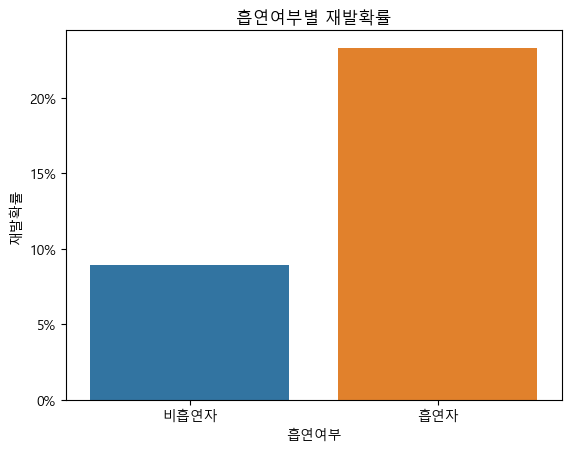

In [140]:
p = df6.pivot_table(index='흡연여부', values='재발여부', aggfunc='mean').reset_index()
sns.barplot(data=p, x='흡연여부', y='재발여부', errorbar=None)
plt.title('흡연여부별 재발확률')
plt.xticks([0, 1], ['비흡연자', '흡연자'])
yt = np.arange(0, 21, 5)
yt2 = []
for i in yt:
    i = str(i) + '%'
    yt2.append(i)

plt.ylabel('재발확률')
plt.yticks([0, 0.05, 0.1, 0.15, 0.2], yt2)

당뇨여부별 재발확률 그래프

([<matplotlib.axis.YTick at 0x2a68b48c5b0>,
 [Text(0, 0.0, '0%'),
  Text(0, 0.05, '5%'),
  Text(0, 0.1, '10%'),
  Text(0, 0.15000000000000002, '15%'),
  Text(0, 0.2, '20%'),
  Text(0, 0.25, '25%'),
  Text(0, 0.30000000000000004, '30%'),
  Text(0, 0.35000000000000003, '35%')])

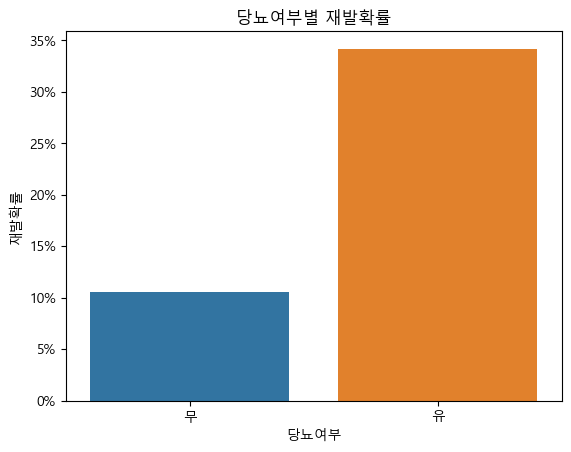

In [148]:
p = df6.pivot_table(index='당뇨여부', values='재발여부', aggfunc='mean').reset_index()
sns.barplot(data=p, x='당뇨여부', y='재발여부', errorbar=None)
plt.title('당뇨여부별 재발확률')
plt.xticks([0, 1], ['무', '유'])
yt = np.arange(0, 36, 5)
yt2 = []
for i in yt:
    i = str(i) + '%'
    yt2.append(i)
plt.ylabel('재발확률')
plt.yticks(np.arange(0, 0.36, 0.05), yt2)

고혈압여부별 재발확률 그래프

([<matplotlib.axis.YTick at 0x2a68b518760>,
 [Text(0, 0.0, '0.0%'),
  Text(0, 0.025, '2.5%'),
  Text(0, 0.05, '5.0%'),
  Text(0, 0.07500000000000001, '7.5%'),
  Text(0, 0.1, '10.0%'),
  Text(0, 0.125, '12.5%'),
  Text(0, 0.15000000000000002, '15.0%'),
  Text(0, 0.17500000000000002, '17.5%')])

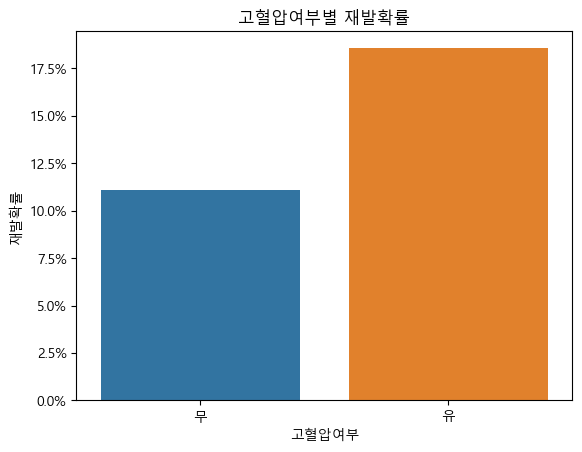

In [150]:
p = df6.pivot_table(index='고혈압여부', values='재발여부', aggfunc='mean').reset_index()
sns.barplot(data=p, x='고혈압여부', y='재발여부', errorbar=None)
plt.title('고혈압여부별 재발확률')
plt.xticks([0, 1], ['무', '유'])
yt = np.arange(0, 17.6, 2.5)
yt2 = []
for i in yt:
    i = str(i) + '%'
    yt2.append(i)
plt.ylabel('재발확률')
plt.yticks(np.arange(0, 0.176, 0.025), yt2)

심혈관질환여부별 재발확률 그래프

([<matplotlib.axis.YTick at 0x2a68b63a980>,
 [Text(0, 0.0, '0.0%'),
  Text(0, 0.025, '2.5%'),
  Text(0, 0.05, '5.0%'),
  Text(0, 0.07500000000000001, '7.5%'),
  Text(0, 0.1, '10.0%'),
  Text(0, 0.125, '12.5%'),
  Text(0, 0.15000000000000002, '15.0%'),
  Text(0, 0.17500000000000002, '17.5%'),
  Text(0, 0.2, '20.0%')])

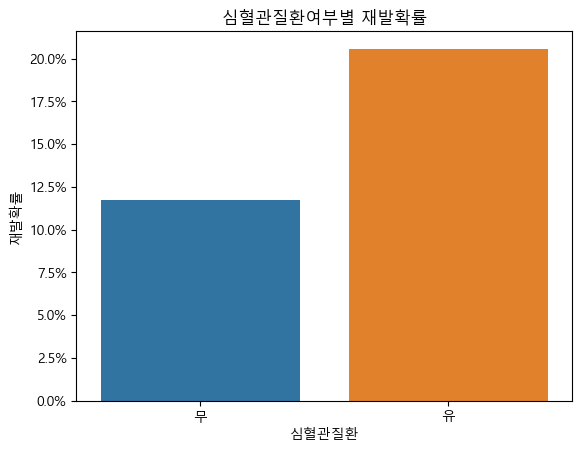

In [153]:
p = df6.pivot_table(index='심혈관질환', values='재발여부', aggfunc='mean').reset_index()
sns.barplot(data=p, x='심혈관질환', y='재발여부', errorbar=None)
plt.title('심혈관질환여부별 재발확률')
plt.xticks([0, 1], ['무', '유'])
yt = np.arange(0, 20.1, 2.5)
yt2 = []
for i in yt:
    i = str(i) + '%'
    yt2.append(i)
plt.ylabel('재발확률')
plt.yticks(np.arange(0, 0.201, 0.025), yt2)

재발한 환자 성비

([<matplotlib.axis.XTick at 0x2a69712bdc0>,
 [Text(0, 0, '남자'), Text(1, 0, '여자')])

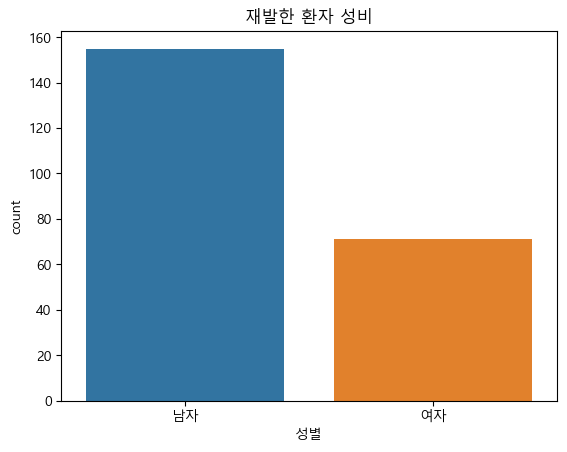

In [220]:
sns.countplot(data=df6[df6['재발여부'] == 1], x='성별')
plt.title('재발한 환자 성비')
plt.xticks([0, 1], ['남자', '여자'])

성별에 따른 재발확률

([<matplotlib.axis.XTick at 0x2a698304190>,
 [Text(0, 0, '남자'), Text(1, 0, '여자')])

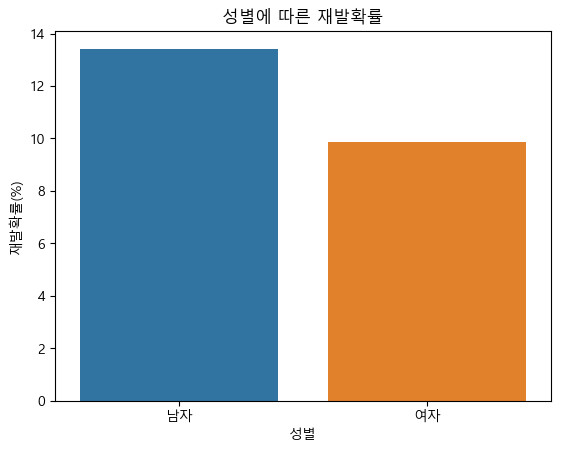

In [236]:
p = df6.pivot_table(index='성별', columns='재발여부', values='환자ID', aggfunc='count')
p['전체'] = p[0] + p[1]
p['재발확률'] = p[1] / p['전체'] * 100
p = p.reset_index()

sns.barplot(p, x='성별', y='재발확률')
plt.title('성별에 따른 재발확률')
plt.ylabel('재발확률(%)')
plt.xticks([0, 1], ['남자', '여자'])

재발한 환자 연령대 별 성비

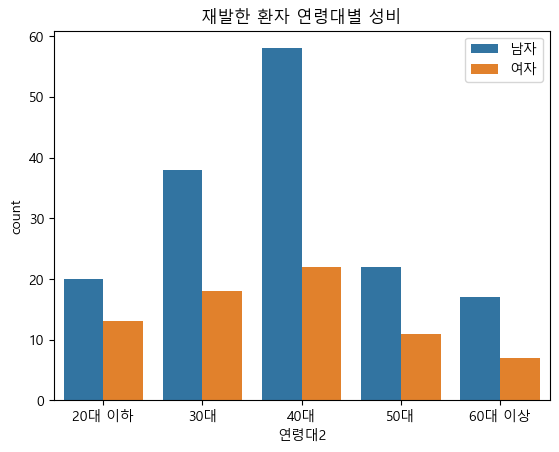

In [89]:
sns.countplot(df6[df6['재발여부'] == 1], x='연령대2', order=['20대 이하', '30대', '40대', '50대', '60대 이상'], hue='성별')
plt.title('재발한 환자 연령대별 성비')
plt.legend(['남자', '여자'])

연령대 별 각 성별의 재발확률

Text(0, 0.5, '재발확률(%)')

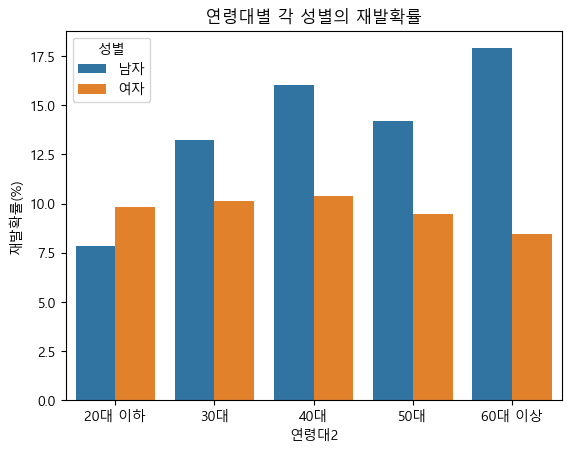

In [91]:
p = df6.pivot_table(index=['연령대2', '성별'], columns='재발여부', values='환자ID', aggfunc='count')
p.fillna(0, inplace=True)
p['전체'] = p[0] + p[1]
p['재발확률'] = p[1] / p['전체'] * 100
p = p.reset_index()
p['성별'].replace({1: '남자', 2: '여자'}, inplace=True)
p
sns.barplot(p, x='연령대2', y='재발확률', hue='성별')
plt.title('연령대별 각 성별의 재발확률')
plt.ylabel('재발확률(%)')

직업 별 재발한 환자 수

Text(0.5, 1.0, '직업별 재발한 환자 수')

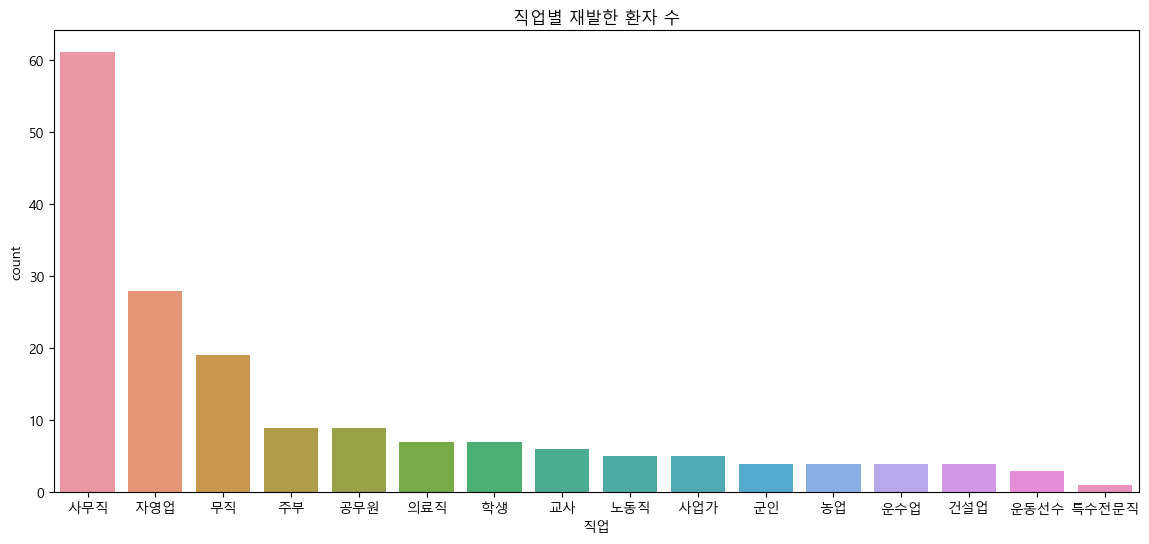

In [264]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df6[df6['재발여부'] == 1], x='직업', order=df6[df6['재발여부'] == 1]['직업'].value_counts().index)
plt.title('직업별 재발한 환자 수')

직업 별 재발 확률

Text(0, 0.5, '재발확률(%)')

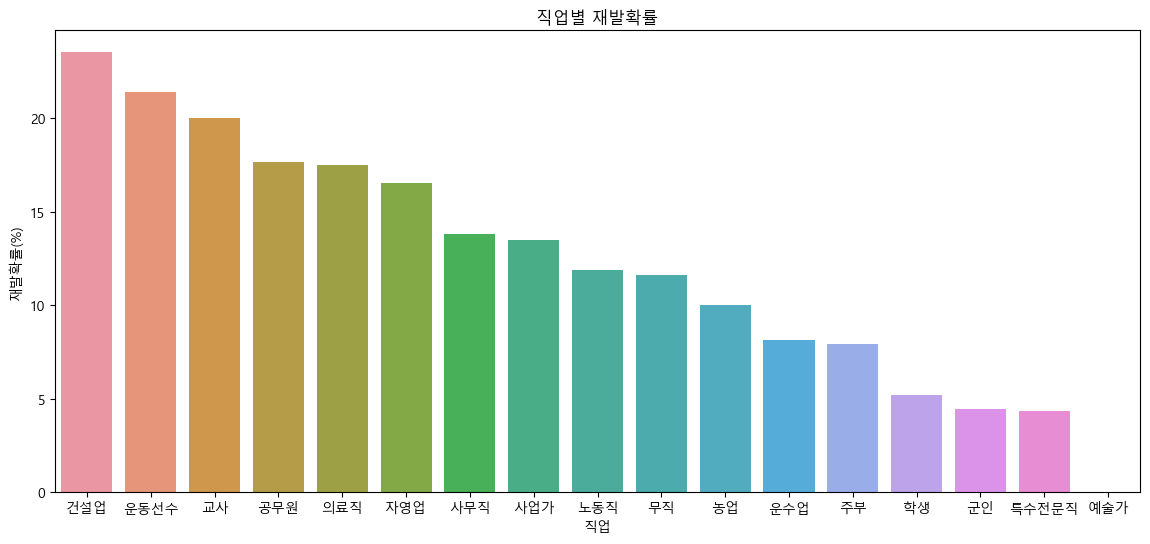

In [20]:
p = df6.pivot_table(index='직업', columns='재발여부', values='환자ID', aggfunc='count')
p.loc['예술가'][1] = 0
p['전체'] = p[0] + p[1]
p['재발확률'] = p[1] / p['전체'] * 100
p = p.reset_index()
p = p.set_index(p['직업'].values)
p = p.sort_values(by='재발확률', ascending=False)
p

plt.figure(figsize=(14, 6))
sns.barplot(p, x='직업', y='재발확률')
plt.title('직업별 재발확률')
plt.ylabel('재발확률(%)')

### ------------------------------------------------------

In [348]:
df6[df6['흡연여부'] == 1]['연령+성별'].value_counts()

30대1       97
40대1       89
20대 이하1    67
50대1       45
40대2       35
30대2       20
20대 이하2    19
60대 이상1    15
50대2       11
60대 이상2    10
Name: 연령+성별, dtype: int64

40대 남성들의 직업 top5

In [84]:
cond1 = (df6['성별'] == 1)
cond2 = (df6['연령대'] == '40대')
df6[cond1 & cond2]['직업'].value_counts()

사무직      80
자영업      49
주부       24
공무원      15
노동직      14
사업가      11
무직       10
운수업       8
의료직       7
교사        7
특수전문직     6
군인        5
농업        4
건설업       4
운동선수      2
Name: 직업, dtype: int64

In [93]:
p = df6[df6['재발여부'] == 1].pivot_table(index='연령대2', columns=['성별'], values='환자ID', aggfunc='count')
p['남녀'] = p[1] + p[2]
p['퍼센트'] = p['남녀'] / p['남녀'].sum() * 100
p

성별,1,2,남녀,퍼센트
연령대2,,,,
20대 이하,20,13,33,14.601770
30대,38,18,56,24.778761
40대,58,22,80,35.398230
50대,22,11,33,14.601770
60대 이상,17,7,24,10.619469


### 머신러닝

In [317]:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [318]:
df7 = df6.drop(['입원기간', '간질성폐질환', '혈전합병증여부', '말초동맥질환여부', '암발병여부', '종양진행여부', '신부전여부', '환자ID', 'ODI', '골밀도', '입원일자', '퇴원일자', '수술일자', 'BMI', '연령대', '연령대2', '연령+성별', '수술일자_dt', '입원일자_dt', '퇴원일자_dt'], axis=1)
df7['직업'].fillna('미상', inplace=True)
df7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1875 entries, 0 to 1893
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   전방디스크높이(mm)             1875 non-null   float64
 1   후방디스크높이(mm)             1875 non-null   float64
 2   지방축적도                   1875 non-null   float64
 3   Instability             1875 non-null   object 
 4   MF + ES                 1875 non-null   float64
 5   Modic change            1875 non-null   object 
 6   PI                      1875 non-null   float64
 7   PT                      1875 non-null   float64
 8   Seg Angle(raw)          1875 non-null   float64
 9   Vaccum disc             1875 non-null   object 
 10  디스크단면적                  1875 non-null   float64
 11  디스크위치                   1875 non-null   object 
 12  척추이동척도                  1875 non-null   object 
 13  척추전방위증                  1875 non-null   object 
 14  Large Lymphocyte        1875 non-null   

In [319]:
x = df7.drop('재발여부', axis=1)
y = df7['재발여부'].astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=123)

In [320]:
num_col = x.describe().columns.tolist()
num_p = make_pipeline(SimpleImputer(strategy='mean'),
                      MinMaxScaler())

cat_col = x.describe(include='object').columns.tolist()
cat_p = make_pipeline(SimpleImputer(strategy='most_frequent'),
                      OneHotEncoder(handle_unknown='ignore'))

preprocessing_p = make_column_transformer((num_p, num_col),
                                          (cat_p, cat_col))
preprocessing_p

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['전방디스크높이(mm)', '후방디스크높이(mm)', '지방축적도',
                                  'MF + ES', 'PI', 'PT', 'Seg Angle(raw)',
                                  '디스크단면적', 'Large Lymphocyte', '신장', '연령',
                                  '체중', '헤모글로빈수치', '환자통증정도', '통증기간(월)',
                                  '수술시간']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Instability', 'Modic change', 'Vaccum disc',
                                  '디스크위치', '척추이동척도', '척추전방위증',
                                  'Location of herniation', '가족력', '고혈압여부',
                                  '과거수술횟수', '당뇨여부', '빈혈여부', '성별', '스테로이드치료',
                                  '심혈관질환', '우울증여부', '직업', '흡연여부', '수술기법',
                                  '수술실패여부', '혈액형', 'BMI_cat'])])

DecisionTree

In [637]:
model_p_dt = make_pipeline(preprocessing_p,
                        #    SMOTE(),
                           DecisionTreeClassifier())

In [638]:
grid_model_dt = GridSearchCV(model_p_dt, cv=3, param_grid={}, scoring='f1', n_jobs=-1)
grid_model_dt.fit(x_train, y_train)
best_model_dt = grid_model_dt.best_estimator_

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


RandomForest

In [640]:
model_p_rf = make_pipeline(preprocessing_p,
                        # SMOTE(),
                        RandomForestClassifier())

In [641]:
grid_model_rf = GridSearchCV(model_p_rf, cv=3, param_grid={}, scoring='f1', n_jobs=-1)
grid_model_rf.fit(x_train, y_train)
best_model_rf = grid_model_rf.best_estimator_

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


LGBM

In [353]:
help(LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(sklearn.base.ClassifierMixin, LGBMModel)
 |  LGBMClassifier(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable, NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None, n_jobs: int = -1, silent: Union[bool, str] = 'warn', importance_type: str = 'split', **kwargs)
 |  
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      sklearn.base.ClassifierMixin
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Met

In [326]:
model_p_lgbm = make_pipeline(preprocessing_p,
                            #ADASYN(),
                             LGBMClassifier(class_weight='balanced',
                                            min_child_weight=0.1
                                            ))

In [322]:
hyperparameter_lgbm = {
                      }
'''
boosting_type
num_leaves
max_depth
learning_rate
n_estimators
'''


'\nboosting_type\nnum_leaves\nmax_depth\nlearning_rate\nn_estimators\n'

In [327]:
grid_model_lgbm = GridSearchCV(model_p_lgbm, cv=5, param_grid=hyperparameter_lgbm, scoring='f1', n_jobs=-1)
grid_model_lgbm.fit(x_train, y_train)
best_model_lgbm = grid_model_lgbm.best_estimator_
best_model_lgbm.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    ['전방디스크높이(mm)', '후방디스크높이(mm)', '지방축적도',
                                     'MF + ES', 'PI', 'PT', 'Seg Angle(raw)',
                                     '디스크단면적', 'Large Lymphocyte', '신장', '연령',
                                     '체중', '헤모글로빈수치', '환자통증정도', '통증기간(월)',
                                     '수술시간']),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                

In [328]:
encoder_list = best_model_lgbm.named_steps['columntransformer'].transformers_[1][1].named_steps['onehotencoder'].get_feature_names_out().tolist()
model_columns_list = x.describe().columns.tolist() + encoder_list
feature_importance = best_model_lgbm['lgbmclassifier'].feature_importances_
df_importance = pd.DataFrame({'Feature' : model_columns_list, 
                              'Importance' : feature_importance})
df_importance['per'] = round(df_importance['Importance'] / df_importance['Importance'].sum() * 100, 2)
df_importance.sort_values(by='per', ascending=False).head(10)

,Feature,Importance,per
7,디스크단면적,301,10.03
6,Seg Angle(raw),237,7.90
3,MF + ES,226,7.53
1,후방디스크높이(mm),216,7.20
2,지방축적도,214,7.13
11,체중,182,6.07
4,PI,172,5.73
8,Large Lymphocyte,158,5.27
5,PT,155,5.17
15,수술시간,145,4.83


In [246]:
x.describe(include='object').columns

Index(['Instability', 'Modic change', 'Vaccum disc', '디스크위치', '척추이동척도',
       '척추전방위증', 'Location of herniation', '가족력', '고혈압여부', '과거수술횟수', '당뇨여부',
       '빈혈여부', '성별', '스테로이드치료', '심혈관질환', '우울증여부', '직업', '흡연여부', '수술기법',
       '수술실패여부', '혈액형', 'BMI_cat'],
      dtype='object')

In [305]:
# pickle.dump(best_model_lgbm, open('model_lgbm_0.77.sav', 'wb'))

CatBoost

In [246]:
model_p_cb = make_pipeline(preprocessing_p,
                        #    SMOTE(),
                           CatBoostClassifier())

In [247]:
grid_model_cb = GridSearchCV(model_p_cb, cv=3, param_grid={}, scoring='f1', n_jobs=-1)
grid_model_cb.fit(x_train, y_train)
best_model_cb = grid_model_cb.best_estimator_

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Learning rate set to 0.011916
0:	learn: 0.6834479	total: 5.14ms	remaining: 5.13s
1:	learn: 0.6747659	total: 10.6ms	remaining: 5.27s
2:	learn: 0.6655907	total: 15.4ms	remaining: 5.13s
3:	learn: 0.6567330	total: 20.5ms	remaining: 5.1s
4:	learn: 0.6487256	total: 26ms	remaining: 5.18s
5:	learn: 0.6407708	total: 31.1ms	remaining: 5.16s
6:	learn: 0.6325420	total: 36.2ms	remaining: 5.13s
7:	learn: 0.6253396	total: 41.2ms	remaining: 5.11s
8:	learn: 0.6174475	total: 46.5ms	remaining: 5.12s
9:	learn: 0.6104161	total: 52.1ms	remaining: 5.16s
10:	learn: 0.6035756	total: 57.3ms	remaining: 5.15s
11:	learn: 0.5952679	total: 62ms	remaining: 5.11s
12:	learn: 0.5867697	total: 67.1ms	remaining: 5.09s
13:	learn: 0.5799643	total: 72.5ms	remaining: 5.11s
14:	learn: 0.5735234	total: 77.1ms	remaining: 5.06s
15:	learn: 0.5665370	total: 81.9ms	remaining: 5.04s
16:	learn: 0.5601930	total: 87.5ms	remaining: 5.06s
17:	learn: 0.5533145	total: 92.6ms	remaining: 5.05s
18:	learn: 0.5476524	total: 98.1ms	remaining: 5.0

XGBoost

In [626]:
model_p_xgb = make_pipeline(preprocessing_p,
                            #  SMOTE(),
                             XGBClassifier())

In [627]:
grid_model_xgb = GridSearchCV(model_p_xgb, cv=3, param_grid={}, scoring='f1', n_jobs=-1)
grid_model_xgb.fit(x_train, y_train)
best_model_xgb = grid_model_xgb.best_estimator_

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Evaluation

In [28]:
def classifier_evaluation(best_model):
    y_train_pred = best_model.predict(x_train)
    y_test_pred = best_model.predict(x_test)

    print(f'모델: {best_model[1]}')
    print(f'학습 데이터 평가\n{classification_report(y_train, y_train_pred)}')
    print('=' * 60)
    print(f'테스트 데이터 평가\n{classification_report(y_test, y_test_pred)}')

In [329]:
classifier_evaluation(best_model_lgbm)

모델: LGBMClassifier(class_weight='balanced', min_child_weight=0.1)
학습 데이터 평가
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1236
           1       1.00      1.00      1.00       170

    accuracy                           1.00      1406
   macro avg       1.00      1.00      1.00      1406
weighted avg       1.00      1.00      1.00      1406

테스트 데이터 평가
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       413
           1       0.88      0.68      0.77        56

    accuracy                           0.95       469
   macro avg       0.92      0.83      0.87       469
weighted avg       0.95      0.95      0.95       469



재발확률 확인

In [341]:
d = pd.DataFrame({'prob': best_model_lgbm.predict_proba(x_test)[:, 1]})
d['prob'] = d['prob'].round(2)
d.sort_values(by='prob', ascending=False)


,prob
217,1.0
441,1.0
134,1.0
463,1.0
203,1.0
...,...
289,0.0
293,0.0
104,0.0
102,0.0


### ---------------------필요 없는 것들--------------------------

In [19]:
# hue_col = ['Location of herniation', '과거수술횟수', '성별', '직업', '환자통증정도', '흡연여부', '수술기법']

# numeric_col = df2.describe().columns
# category_col = df2.describe(include='object').columns
# category_col = category_col.drop('환자ID')

# for h in ['수술기법']:
#     # for c in category_col:
#         for n in numeric_col:
#             sns.barplot(data=df2, x=h, y=n, estimator='mean', errorbar=None)
#             plt.show()

# print(numeric_col)

# sns.scatterplot(data=df2, x='환자통증정도', y='통증기간(월)', hue='가족력')
# plt.legend(loc='upper right')

# sns.pairplot(df2, hue='수술실패여부')

그래프 그렸던 거

In [20]:
# a = [48.4, 31, 9.5, 33.3, 31]
# b = [51.2, 39.3, 13.1, 28.6, 26.2]
# c = ['물리치료', '약물치료', '운동', '시술', '수술']

# b1 = plt.bar(x=[-0.2, 0.8, 1.8, 2.8, 3.8], height=a, width=0.5)
# b2 = plt.bar(x=[0.2, 1.2, 2.2, 3.2, 4.2], height=b, width=0.5)
# for rect in b1:
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 9)
# for rect in b2:
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 9)
# plt.xticks([0, 1, 2, 3, 4], ['물리치료', '약물치료', '운동', '시술', '수술'])
# plt.legend(('의사가 권유한 치료방법', '실제로 받은 치료방법'))
# plt.grid(axis='y', alpha=0.5)
# plt.show()